# Change point based Clustering

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [5]:
import sys
sys.path.append('../')

In [6]:
from eval.tsdr import load_tsdr_by_chaos

dataset_by_chaos = load_tsdr_by_chaos(
    dataset_id=SOCKSHOP_DATASET_ID, 
    metric_types={
        "services": True,
        "containers": True,
        "middlewares": True,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": False,
        "enable_multireducer": False,
    },
    target_chaos_types={"pod-cpu-hog", "pod-memory-hog", "pod-network-latency"},
    use_manually_selected_metrics=False,
    # from_orig=(True, 180),
    validation_filtering=(True, 4*5)
)

In [7]:
from eval.tsdr import load_tsdr_by_chaos

tt_dataset_by_chaos = load_tsdr_by_chaos(
    TRAINTICKET_DATASET_ID, 
    metric_types={
        "services": True,
        "containers": True,
        "middlewares": True,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": False,
        "enable_multireducer": False,
    },
    target_chaos_types={"pod-cpu-hog", "pod-memory-hog", "pod-network-latency"},
    use_manually_selected_metrics=False,
    # from_orig=(True, 180),
    validation_filtering=(True, 4*5)
)

In [8]:
import pandas as pd

record, data_df_by_metric_type = dataset_by_chaos[("pod-memory-hog", "payment")][3]
print(record.chaos_case_full())
dataset = pd.concat([
    data_df_by_metric_type["containers"][0],
    data_df_by_metric_type["services"][0],
    # data_df_by_metric_type["middlewares"][0],
], axis=1)
dataset.shape, record.chaos_case_file()

payment/pod-memory-hog/9n6mf-1


((180, 183),
 '2023-02-17-argowf-chaos-9n6mf-payment_pod-memory-hog_1.json of payment/pod-memory-hog')

In [9]:
from tsdr.outlierdetection.spot import detect_anomalies_with_spot
from tsdr.outlierdetection.n_sigma_rule import detect_anomalies_with_zscore_nsigma

sli_data: pd.DataFrame = dataset.loc[
    :, [col for col in record.pk.get_root_metrics() if col in dataset.columns]
]  # retrieve only existing slis
most_anomalous_sli_name = sli_data.apply(lambda x: detect_anomalies_with_spot(x.to_numpy(), 4*30)[1]).idxmax()
most_anomalous_sli_data = sli_data[most_anomalous_sli_name].to_numpy()
most_anomalous_sli_name 

's-front-end_latency'

In [10]:
cols = [record.pk.get_container_by_metric(metric) == record.chaos_comp() for metric in dataset.columns]
cause_dataset = dataset.loc[:, cols]

In [11]:
from tsdr.multireducer import change_point_clustering, change_point_clustering_with_kde
from tsdr.smooth import moving_average

In [12]:
# from tsdr import tsdr

# tsdr.Tsdr(enable_unireducer=False, enable_multireducer=True, univariate_series_func_or_name="residual_integral",
#     step2_clustering_method_name="changepoint",
#     step2_changepoint_n_bkps=1,
#     step2_changepoint_proba_threshold=0.5,
#     step2_clustering_choice_method="max_members_changepoint",
#     step2_changepoint_cluster_selection_method="leaf",
#     step2_changepoint_cluster_selection_epsilon=3.0,
#     step2_changepoint_allow_single_cluster=True,
#     step2_clustering_n_workers=1,
# ).reduce_multivariate_series(
#     dataset,
#     record.pk,
#     n_workers=1,
# )

In [20]:
# cinfo, remove_metrics = change_point_clustering(
#     cause_dataset,
#     n_bkps=1,
#     proba_threshold=0.5,
#     choice_method="max_members_changepoint",
#     cluster_selection_epsilon=3.0,
#     cluster_selection_method="leaf",
#     cluster_allow_single_cluster=True,
#     sli_data=sli_data,
#     n_jobs=-1,
# )
cinfo, remove_metrics = change_point_clustering_with_kde(
    cause_dataset,
    cost_model="l2",
    penalty="aic",
    n_bkps=1,
    kde_bandwidth="silverman",
    multi_change_points=True,
    representative_method=True,
    n_jobs=-1,
)
cinfo, remove_metrics

({'c-payment_cpu_usage_seconds_total': [],
  'c-payment_memory_working_set_bytes': [],
  'c-payment_network_transmit_bytes_total': [],
  'c-payment_threads': [],
  'c-payment_cpu_cfs_throttled_seconds_total': [],
  'c-payment_memory_failcnt': [],
  'c-payment_cpu_system_seconds_total': [],
  'c-payment_memory_cache': [],
  'c-payment_network_transmit_packets_total': [],
  'c-payment_memory_usage_bytes': [],
  'c-payment_cpu_cfs_throttled_periods_total': [],
  'c-payment_memory_mapped_file': [],
  'c-payment_cpu_user_seconds_total': [],
  'c-payment_memory_rss': []},
 ['c-payment_network_receive_packets_total',
  'c-payment_network_receive_bytes_total',
  'c-payment_cpu_cfs_periods_total'])

In [ ]:
import ruptures as rpt
import hdbscan 
from hdbscan.prediction import all_points_membership_vectors, all_points_outlier_membership_vector

from collections import defaultdict
import itertools

In [ ]:
# cause_dataset = cause_dataset.apply(lambda x: moving_average(x, window_size=5))
# sli_data = sli_data.apply(lambda x: moving_average(x, window_size=5))

162

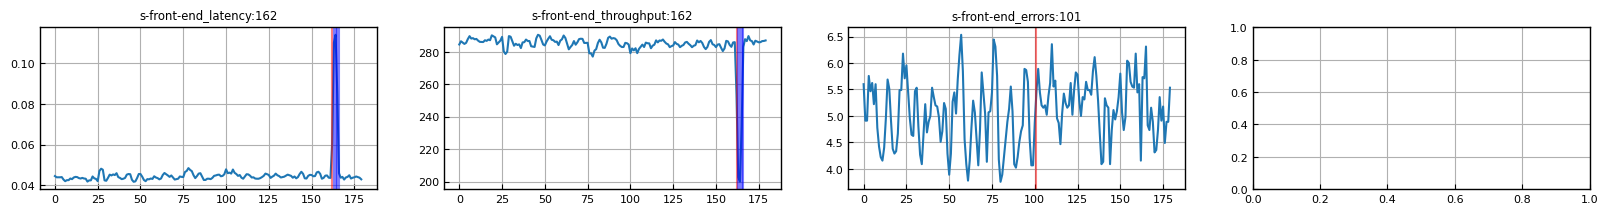

In [ ]:
import math

binseg = rpt.Binseg(model="l2", jump=1)
fig, axs = plt.subplots(math.ceil(sli_data.shape[1]/4), ncols=4)
fig.set_size_inches(20, 0.7*sli_data.shape[1])
bkps = []
for ax, sli in zip(axs.flatten(), sli_data.columns):
    sli_y = sli_data[sli].values
    bkp = binseg.fit(scipy.stats.zscore(sli_y)).predict(n_bkps=1)[0]
    bkps.append(bkp)
    ax.plot(sli_y)
    ax.axvline(bkp, color='red', alpha=0.5)
    ax.set_title(f"{sli}:{bkp}")

    backward_idx = 4*20
    alarms, scores = detect_anomalies_with_spot(sli_y, anomalous_start_idx=backward_idx, return_score=True, proba=1e-4)
    # alarms, scores = detect_anomalies_with_zscore_nsigma(sli_y, anomalous_start_idx=backward_idx, return_score=True, n_sigmas=3.0, robust=True)
    for alarm in alarms:
        a = (sli_y.size - backward_idx) + alarm
        ax.axvline(a, color='blue', alpha=0.5)
    # _bkps = binseg.fit(scipy.stats.zscore(sli_y)).predict(n_bkps=1)[:-1]
    # for bkp in _bkps:
    #     ax.axvline(bkp, color='green', alpha=0.7)
    
slis_bkp: int = binseg.fit(sli_data.apply(scipy.stats.zscore).values).predict(n_bkps=1)[0]
slis_bkp

## Change points detection

In [ ]:
data = cause_dataset
n_bkps = 1
total_bkp = rpt.Binseg(model="l2", jump=1).fit(data.to_numpy()).predict(n_bkps=n_bkps)[:-1]
print(
    "multivariate bkp", total_bkp
)

multivariate bkp [163]


In [ ]:
from tsdr.outlierdetection.n_sigma_rule import detect_anomalies_with_zscore_nsigma_causerank

metrics = data.columns.tolist()
change_points: list[int] = []
multi_change_points: list[list[int]] = []
data_size = data.shape[0]
for metric in metrics:
    x = data[metric].to_numpy()
    anomaly, scores = detect_anomalies_with_zscore_nsigma_causerank(x, anomalous_start_idx=4*25, n_sigmas=2.0)
    x = scipy.stats.zscore(x)
    # data_size = len(scores)
    # change_point = binseg.fit(scipy.stats.zscore(x)).predict(n_bkps=n_bkps)[0]
    seg = 2
    sigma = np.std(x)
    aic_pen = seg*sigma*sigma
    bic_pen = np.log(x.size) * seg * sigma * sigma
    cps = rpt.Binseg(model="l2", jump=1).fit(x).predict(pen=aic_pen)[:-1]
    multi_change_points.append(cps)
    if len(cps) == 0:
        change_points.append(0)
        continue
    cp_i = np.argmin(np.abs(np.array(cps) - slis_bkp))
    change_points.append(cps[cp_i])
metric_to_bkp = {metric: bkp for metric, bkp in zip(metrics, change_points)}
metric_to_cps = {metric: cps for metric, cps in zip(metrics, multi_change_points)}
cp_to_metrics = defaultdict(list)
for metric, cps in metric_to_cps.items():
    for cp in cps:
        cp_to_metrics[cp].append(metric)

kde bandwidth 0.4568491137802365


,metric,cluster_label,change_point
0,c-payment_cpu_system_seconds_total,0,2
1,c-payment_network_transmit_bytes_total,0,4
2,c-payment_network_transmit_packets_total,0,4
3,c-payment_network_receive_packets_total,0,4
4,c-payment_network_receive_bytes_total,0,4
5,c-payment_network_transmit_bytes_total,1,26
6,c-payment_network_receive_packets_total,1,26
7,c-payment_network_receive_bytes_total,1,26
8,c-payment_cpu_system_seconds_total,2,29
9,c-payment_network_transmit_bytes_total,2,30


158


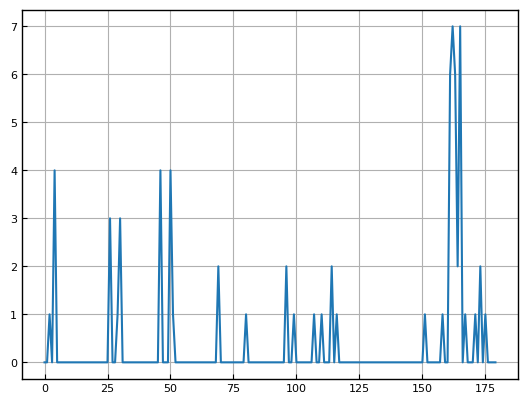

In [ ]:
from scipy.signal import argrelextrema
from sklearn.neighbors import KernelDensity

flat_change_points = sum(multi_change_points, []) # flatten
x = np.array(flat_change_points, dtype=int)
kde = KernelDensity(kernel='gaussian', bandwidth="silverman").fit(x.reshape(-1, 1))
print(f"kde bandwidth {kde.bandwidth_}")
minval, maxval = 0, data_size - 1
s = np.linspace(minval, maxval, num=data_size // 2)
e = kde.score_samples(s.reshape(-1, 1))
# display(list(zip(b, e)))
# plt.plot(e)

mi = argrelextrema(e, np.less)[0]

def unique_values(x, x_i):
    return np.unique(x[x_i])

clusters = []
if len(mi) <= 0:
    print("1 cluster")
    clusters.append(unique_values(x, np.arange(len(x))))
else:
    clusters.append(unique_values(x, [np.where(x < s[mi][0])[0]]))  # most left cluster
    # all middle cluster
    for i_cluster in range(len(mi)-1):
        clusters.append(unique_values(x, [np.where((x >= s[mi][i_cluster]) * (x <= s[mi][i_cluster+1]))][0]))
    clusters.append(unique_values(x, np.where(x >= s[mi][-1])[0]))  # most right cluster

# def find_medoid(arr):
#     sums_of_distances = []
#     for value in arr:
#         sum_of_distances = np.sum(np.abs(arr - value))
#         sums_of_distances.append(sum_of_distances)
#     return arr[np.argmin(sums_of_distances)]

cluster_labels = []
_metrics = []
_change_points = []
for cluster_id, cluster in enumerate(clusters):
    for cp in cluster:
        members = cp_to_metrics[cp]
        cluster_labels.extend([cluster_id for _ in range(len(members))])
        _metrics.extend(members)
        _change_points.extend([cp for _ in range(len(members))])

with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", 0):
    display(pd.DataFrame(zip(_metrics, cluster_labels, _change_points), columns=["metric", "cluster_label", "change_point"]).sort_values("change_point"))

__x = np.zeros(data_size, dtype=int)
for cp, members in cp_to_metrics.items():
    __x[cp] = len(members)
plt.plot(np.arange(__x.size), __x)

max_cluster = max(clusters, key=len)
# representative_bkp = find_medoid(max_cluster)
representative_bkp = max_cluster[0]
print(representative_bkp)
# metric_to_bkp = {metric: cps[np.argmin(np.abs(cps - representative_bkp))] if len(cps) > 0 else 0 for metric, cps in metric_to_cps.items()}
# change_points = list(metric_to_bkp.values())
# print(change_points)

## Gradient-based change point detection

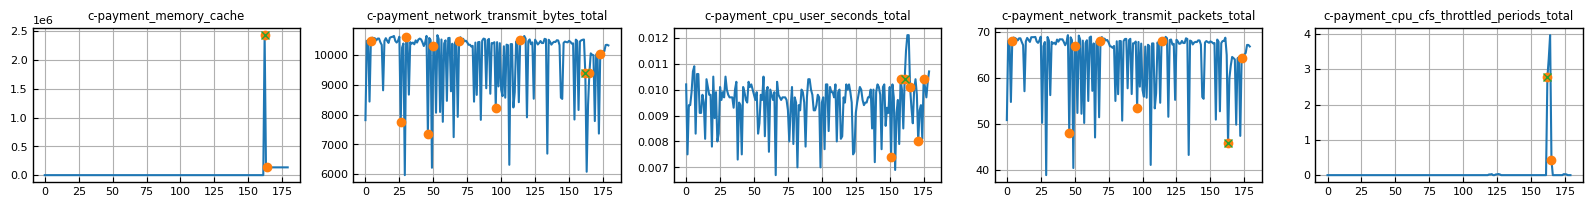

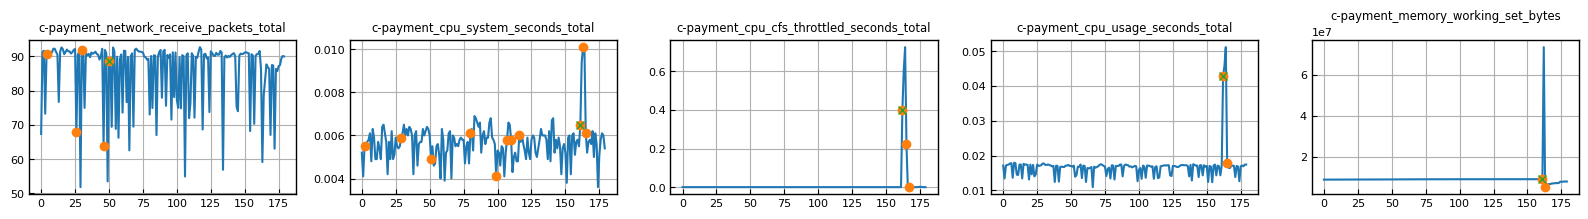

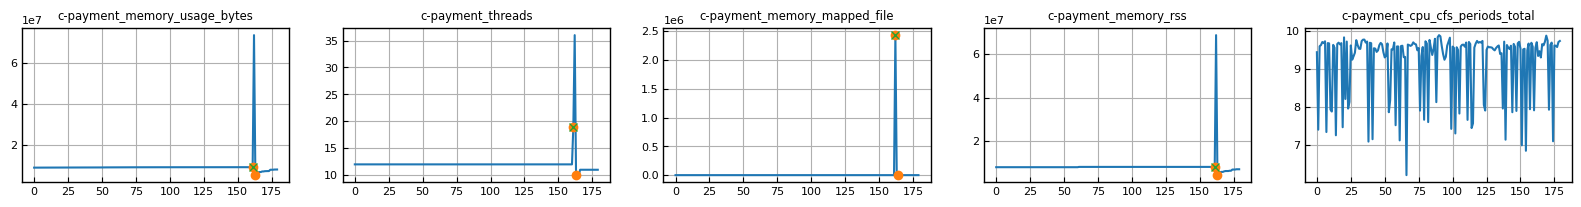

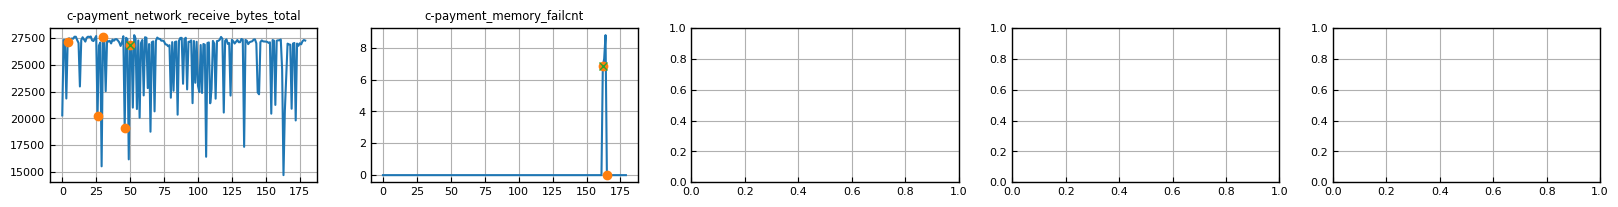

In [ ]:
from scipy.signal import argrelextrema
from sklearn.neighbors import KernelDensity

def rollback(self):
    for x in change_points:
        index = self.data.index(x)
        while index > 0:
            tangent1 = self.data[index-1] - self.data[index]
            tangent2 = self.calculate_tangent(self.data[index-2], self.data[index-1])

            if abs(tangent1 - tangent2) < self.threshold:
                index -= 1
            else:
                break

        self.abnormal_change_points.append(self.data[index])

def critical_change_point(X, change_points):
    grad = np.abs(np.gradient(X))
    grad_max_t = np.argmax(grad)
    nearest_i = np.abs(change_points - grad_max_t).argmin()
    return change_points[nearest_i]


def batch(iterable, n):
    length = len(iterable)
    for i in range(0, length, n):
        yield iterable[i:min(i + n, length)]


for __metrics in batch(cause_dataset.columns.tolist(), 5):
    fig, axs = plt.subplots(1, 5, figsize=(20, 2))
    for metric, ax in zip(__metrics, axs):
        x = cause_dataset[metric].to_numpy()
        # anomaly, scores = detect_anomalies_with_zscore_nsigma_causerank(x, anomalous_start_idx=4*25, n_sigmas=2.0)
        # x_ = moving_average(x, window_size=5)

        seg = 2
        sigma = np.std(x)
        aic_pen = seg*sigma*sigma
        bic_pen = np.log(x.size) * seg * sigma * sigma
        algo = rpt.Binseg(model="l2", jump=1)
        _change_points = np.array(algo.fit(x).predict(pen=aic_pen)[:-1], dtype=int)
        # change_points = np.array(algo.fit(x).predict(n_bkps=1)[:-1], dtype=int)
        # ccp = critical_change_point(x, change_points)

        # sigma = np.std(scores)
        # aic_pen = seg*sigma*sigma
        # bic_pen = np.log(scores.size) * 2 * sigma * sigma
        # scores_change_points = np.array(pelt.fit(scores).predict(pen=aic_pen)[:-1], dtype=int)
        # algo = rpt.Binseg(model="l2", jump=1)
        # scores_change_points = np.array(algo.fit(scores).predict(pen=aic_pen)[:-1], dtype=int)
        # max_score_i = np.argmax(scores)
        # scores_ccp = critical_change_point(scores, scores_change_points)
        # cp = change_points[np.argmin(np.abs(change_points - max_score_i))]    
        # cp_j = np.argmax(scores_change_points[max_score_i])
        # scores_cp = change_points[cp_j]
        # gx = np.abs(np.gradient(x))
        # change_point = np.argmax(gx)

        ax.plot(x)
        ax.set_title(metric)
        if len(_change_points) < 1:
            continue
        ax.plot(_change_points, x[_change_points], 'o')
        # axs[0].plot(ccp, x[ccp], 'x')
        # axs[1].plot(scores)
        # # plt.plot(cp, scores[cp], 'o')
        # axs[1].plot(scores_change_points, scores[scores_change_points], 'o')

        cp_i = np.argmin(np.abs(_change_points - representative_bkp))
        bkp = _change_points[cp_i]
        ax.plot(bkp, x[bkp], 'x')
        # axs[1].plot(bkp, scores[bkp], 'x')
plt.show()
plt.clf()
plt.close("all")


## KDE 1d clustering

,metric,cluster_id,change_point
14,c-payment_cpu_cfs_periods_total,0,0
5,c-payment_network_receive_packets_total,1,50
15,c-payment_network_receive_bytes_total,1,50
2,c-payment_cpu_user_seconds_total,2,161
13,c-payment_memory_rss,2,161
6,c-payment_cpu_system_seconds_total,2,161
11,c-payment_threads,2,161
9,c-payment_memory_working_set_bytes,2,161
10,c-payment_memory_usage_bytes,2,161
0,c-payment_memory_cache,2,162


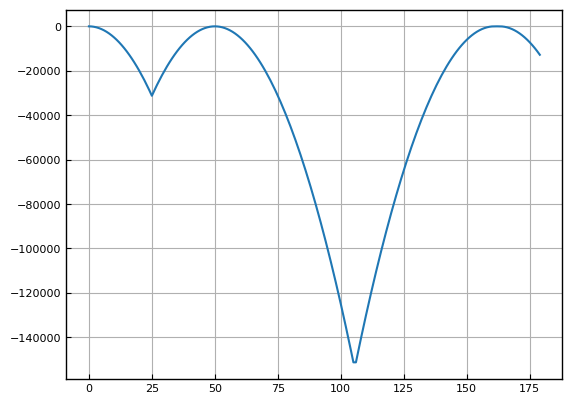

In [ ]:
from scipy.signal import argrelextrema
from sklearn.neighbors import KernelDensity

# x = np.diff(a)
x = np.array(change_points, dtype=int)
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(x.reshape(-1, 1))
minval, maxval = 0, data_size - 1
s = np.linspace(minval, maxval, num=data_size)
e = kde.score_samples(s.reshape(-1, 1))
# display(list(zip(b, e)))
plt.plot(e)

mi = argrelextrema(e, np.less)[0]

clusters = []
if len(mi) <= 0:
    print("1 cluster")
    clusters.append(np.arange(len(x)))
else:
    clusters.append(np.where(x < s[mi][0])[0])  # most left cluster
    # all middle cluster
    for i_cluster in range(len(mi)-1):
        clusters.append(np.where((x >= s[mi][i_cluster]) * (x <= s[mi][i_cluster+1]))[0])
    clusters.append(np.where(x >= s[mi][-1])[0])  # most right cluster

x_indice_to_cluster_id = {x_indice: cluster_id for cluster_id, x_indices in enumerate(clusters) for x_indice in x_indices}
cluster_labels = np.array([x_indice_to_cluster_id[x_indice] for x_indice in range(len(x))])
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.width", 0):
    display(pd.DataFrame(zip(metrics, cluster_labels, x), columns=["metric", "cluster_id", "change_point"]).sort_values("change_point"))

In [ ]:
cluster_id_to_metrics = {cluster_id: [metrics[x_indice] for x_indice in x_indices] for cluster_id, x_indices in enumerate(clusters)}

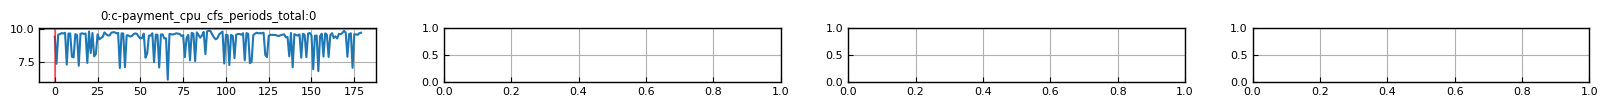

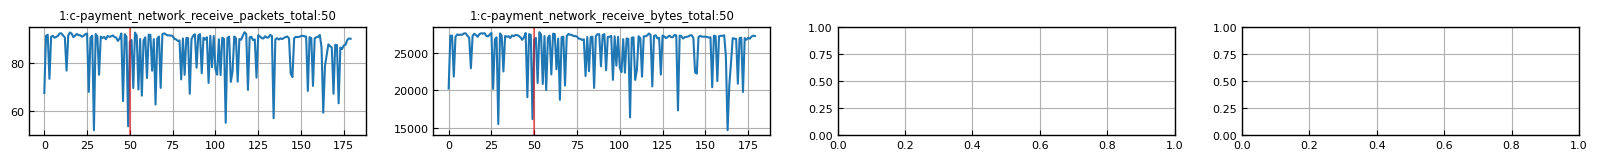

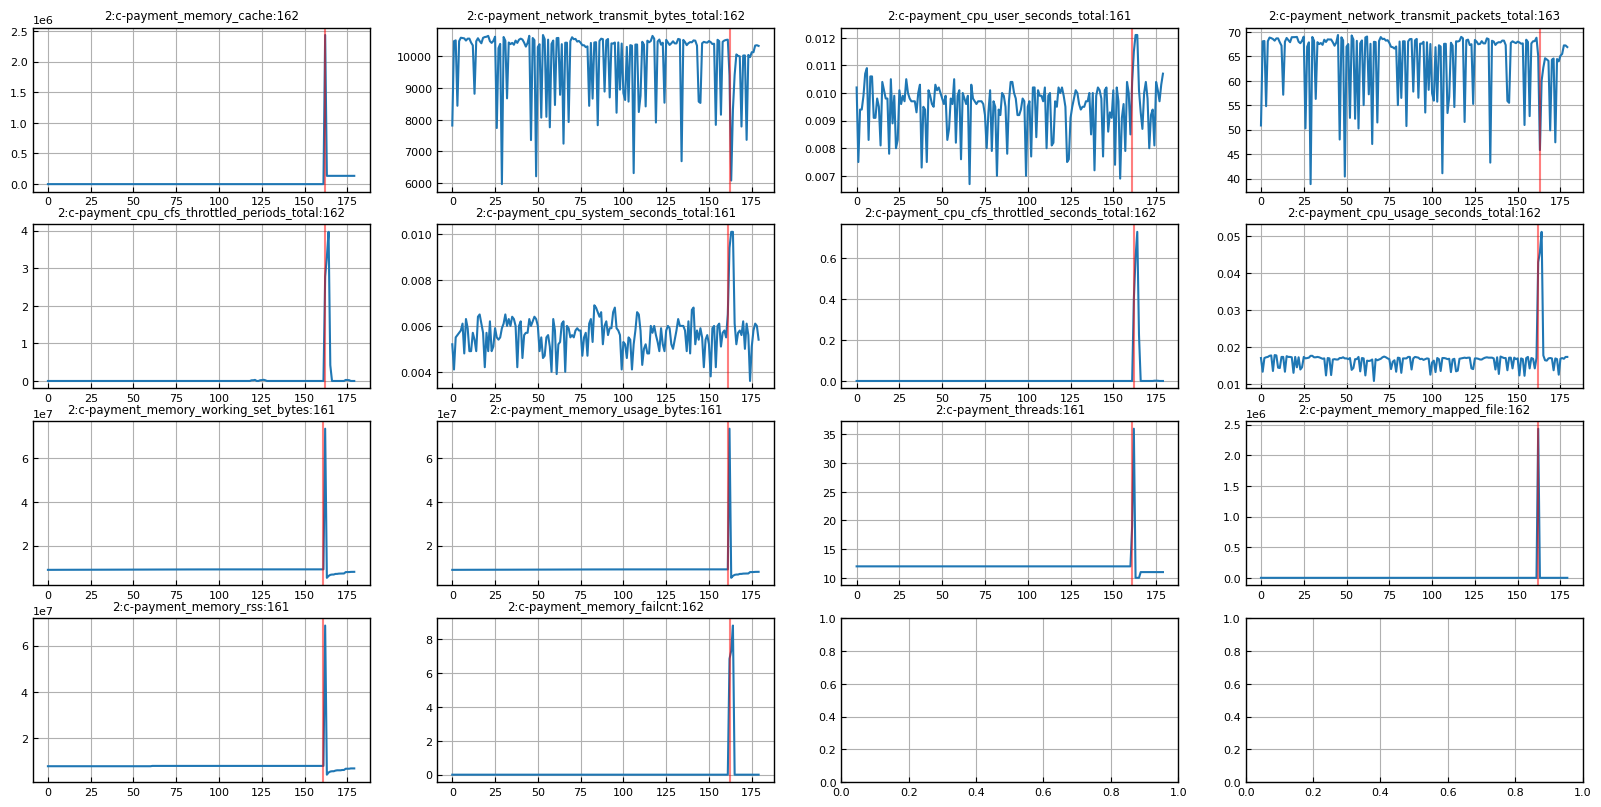

In [ ]:
import math
from notebooklib import plot

plt.close()

for cluster_id, metrics in cluster_id_to_metrics.items():
    fig, axs = plt.subplots(math.ceil(len(metrics)/4), ncols=4)
    fig.set_size_inches(20, 0.7*len(metrics))
    for ax, member in zip(axs.flatten(), metrics):
        metric = member
        x = cause_dataset[metric].to_numpy()
        ax.plot(x)
        bkp = metric_to_bkp[metric]
        ax.axvline(bkp, color='red', alpha=0.5)
        ax.set_title(f"{cluster_id}:{metric}:{bkp}")